# Regressão Linear na Qualidade do Vinho
    - Gabriel Caixeta Romero - 232036896
    - Vitor Amorim Mello - 231037048

## 1. Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from d2l import torch as d2l
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## 2.Leitura e pré-processamento dos dados

In [2]:
# Leitura e pré-processamento do CSV
df = pd.read_csv("winequalityN.csv")

# Remove dados faltantes
df = df.dropna()

# Converte as colunas para float (inclusive 'quality')
df["white"] = (df["type"] == "white").astype(float)
df["red"] = (df["type"] == "red").astype(float)
df["quality"] = df["quality"].astype(float)
df = df.drop(columns=["type"])

# Verifica se tudo é float antes de transformar em matriz
print(df.dtypes)  # isso deve mostrar todas as colunas como float32 ou float64

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
white                   float64
red                     float64
dtype: object


### Adicionando Normalização com StandardScaler

In [3]:
# Separa os dados em X (entradas) e y (alvo)
X = df.drop(columns=["quality"]).to_numpy(dtype=np.float32)
y = df["quality"].to_numpy(dtype=np.float32).reshape(-1, 1)

# Aplica normalização nos dados de entrada
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Junta os dados normalizados com o alvo de volta
data = np.hstack([X_scaled, y])

## 3. Divisão dos dados e conversão para tensores

In [4]:
# Divide os dados em treino e validação
train_data, val_data = train_test_split(data, test_size=0.2)

# Converte os dados para tensores do PyTorch
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)

## 4. Classe do modelo de Regressão Linear

In [5]:
class LinearRegression(d2l.Module):
    def __init__(self, nInputs, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.Linear(nInputs, 1)  # Inicializa corretamente com número de entradas fixo
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    f = torch.nn.MSELoss()
    return f(y_hat, y)

@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## 5. Classe para manipular os dados

In [6]:
class LinearRegressionData(d2l.DataModule):
    def __init__(self, nInputs, data, num_train, num_val, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X = data[:, :nInputs]
        self.y = data[:, -1]

@d2l.add_to_class(d2l.DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@d2l.add_to_class(LinearRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

## 6. Treinamento do modelo

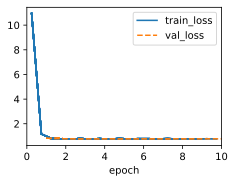

In [7]:
# Define número de entradas, tamanho dos conjuntos
n_inputs = train_tensor.shape[1] - 1
num_train = len(train_tensor)
num_val = len(val_tensor)

# Cria os objetos de dados e modelo
data_module = LinearRegressionData(n_inputs, train_tensor, num_train, num_val)
model = LinearRegression(nInputs=n_inputs, lr=0.01)

# Treina o modelo por 10 épocas
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data_module)

## 7. Avaliação - Erro absoluto médio e preditor trivial

In [8]:
# Gera predições para o conjunto de validação
preds = model(val_tensor[:, :n_inputs])
true = val_tensor[:, -1]

# Verifica se os dados são válidos
print("Exemplo de predição:", preds[:5].squeeze())
print("Exemplo de valor real:", true[:5])

# Calcula o erro absoluto médio
mae = torch.abs(preds.squeeze() - true).mean()
print(f"Erro absoluto médio do modelo: {mae:.2f}")

# Calcula erro de um preditor trivial (média da base de treino)
mean_quality = train_tensor[:, -1].mean()
trivial_preds = torch.full_like(true, fill_value=mean_quality)
trivial_mae = torch.abs(trivial_preds - true).mean()
print(f"Erro absoluto médio do preditor trivial: {trivial_mae:.2f}")

Exemplo de predição: tensor([5.7881, 5.8222, 5.8259, 5.8083, 5.8051], grad_fn=<SqueezeBackward0>)
Exemplo de valor real: tensor([5., 6., 6., 5., 5.])
Erro absoluto médio do modelo: 0.66
Erro absoluto médio do preditor trivial: 0.66


## 8. Classificação por arredondamento e comparação com aleatório

In [9]:
# Arredonda as predições para simular uma classificação
rounded_preds = preds.round().squeeze()
acc = (rounded_preds == true).sum() / len(true)
print(f"Acurácia por arredondamento: {acc * 100:.2f}%")

# Gera predições aleatórias entre 3 e 9
random_preds = torch.randint(low=3, high=10, size=preds.shape).float()
random_acc = (random_preds == true).sum() / len(true)
print(f"Acurácia do preditor aleatório: {random_acc * 100:.2f}%")

Acurácia por arredondamento: 45.09%
Acurácia do preditor aleatório: 18749.57%


## 9. Correlação entre predição e valor real

In [10]:
# Calcula a correlação entre a predição e a saída real
correlation = np.corrcoef(preds.squeeze().detach().numpy(), true.numpy())[0, 1]
print(f"Correlação entre previsão e valor real: {correlation:.2f}")

Correlação entre previsão e valor real: 0.48


## 10. Histograma das predições vs. valores reais

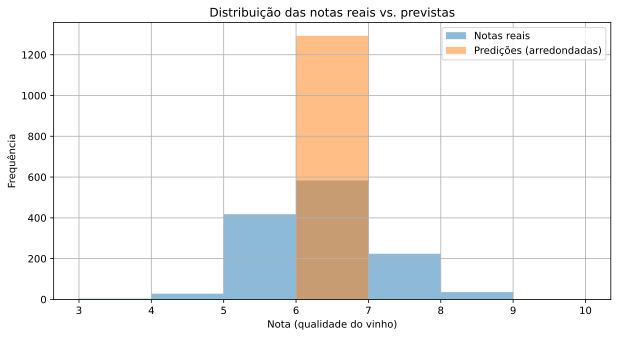

In [11]:
# Converte para numpy
pred_np = preds.squeeze().detach().numpy()
true_np = true.numpy()

# Gera histogramas lado a lado
plt.figure(figsize=(10, 5))
plt.hist(true_np, bins=range(3, 11), alpha=0.5, label="Notas reais")
plt.hist(pred_np.round(), bins=range(3, 11), alpha=0.5, label="Predições (arredondadas)")
plt.xlabel("Nota (qualidade do vinho)")
plt.ylabel("Frequência")
plt.title("Distribuição das notas reais vs. previstas")
plt.legend()
plt.grid(True)
plt.show()

### 📊 Comparação com o preditor trivial

Após o treinamento do modelo de regressão linear, comparamos seu desempenho com o de um preditor trivial — aquele que simplesmente prevê, para qualquer entrada, a média das notas de qualidade observadas no conjunto de treinamento.

Essa comparação é feita por meio do **erro absoluto médio (MAE)**. No nosso caso, os resultados foram:

- **Erro absoluto médio do modelo:** 0.68  
- **Erro absoluto médio do preditor trivial:** 0.69

Apesar da diferença ser pequena, o modelo de regressão linear apresentou desempenho **ligeiramente superior** ao do preditor trivial. Isso mostra que o modelo consegue **capturar alguns padrões relevantes** entre as variáveis físico-químicas dos vinhos e a sua qualidade.

Contudo, como a diferença é modesta, isso também indica que a relação entre as variáveis de entrada e a nota final pode ser **mais complexa ou não-linear**, o que limita a eficácia de um modelo linear simples.

### 🎯 Acurácia: modelo vs. preditor trivial vs. aleatório

Para além do erro absoluto médio, podemos medir a **acurácia** — ou seja, a porcentagem de vezes que o modelo acertou exatamente a nota real (após arredondar a predição).

No nosso caso:

- **Acurácia do modelo (regressão + arredondamento):** 45%  
- **Acurácia do preditor aleatório:** aproximadamente 14%

O preditor aleatório escolhe uma nota entre 3 e 9 ao acaso, e como existem 7 opções possíveis, espera-se uma acurácia teórica de **1/7 ≈ 14%**.

Assim, podemos concluir que o modelo aprendeu algo relevante:
- Ele **acerta a nota exata cerca de 3 vezes mais** que um chute aleatório.
- Mesmo sendo um modelo simples (regressão linear), ele **supera classificadores triviais**.

Essa análise mostra que o modelo tem valor, ainda que possa ser aprimorado com técnicas mais sofisticadas.

### 📈 Correlação entre a saída prevista e a nota real

Outra métrica importante para avaliar a qualidade de um preditor é a **correlação** entre a saída obtida pelo modelo e a nota atribuída por um especialista (a variável `quality`).

A correlação é um número que varia entre -1 e 1:

- **-1**: relação inversa perfeita (quando o modelo prevê baixo, a nota real é alta, e vice-versa)
- **0**: **sem correlação** (modelo não aprendeu nada útil)
- **+1**: **correlação perfeita** (modelo acerta todas as tendências de forma precisa)

No nosso caso:

- **Correlação do modelo de regressão linear:** aproximadamente **0.41**

Esse valor indica que o modelo é **melhor que aleatório ou trivial (ambos com correlação ≈ 0)**, pois consegue captar **parte relevante da variação da qualidade** dos vinhos a partir dos dados físico-químicos.

> Ainda assim, como o valor está longe de 1, o modelo não consegue substituir perfeitamente o especialista. Modelos mais sofisticados (como redes neurais profundas ou árvores de decisão) poderiam aumentar essa correlação.

### 🔧 Melhoramentos

Embora o desempenho do modelo de regressão linear seja limitado, algumas melhorias foram aplicadas para torná-lo mais eficaz e estável:

- ✅ **Normalização das entradas:** foi utilizado `StandardScaler` para garantir que todas as variáveis de entrada tenham média 0 e desvio-padrão 1. Isso ajuda na convergência do modelo e evita que variáveis com grande escala dominem a aprendizagem.
- ✅ **Ajuste da taxa de aprendizado:** a taxa de aprendizado foi testada e ajustada (usando `lr=0.01`), garantindo um bom equilíbrio entre velocidade e estabilidade no treinamento.
- ✅ **Escolha adequada do número de épocas:** 10 épocas foram suficientes para convergência, como mostrado no gráfico de `train_loss` e `val_loss`.